# DASi Submission

**Inputs**

* Session credentials (`config.toml`)
* Sequences at`output_plasmids/*.gb`

**Outputs**

* Inventory csv
* Selected Inventory csv
* Selected Inventory filter txt
* `design.out.json`

*Note: this script takes 10-25 minutes for ~32 plasmids. Please be patient.

In [1]:
import dasi
print(dasi.__version__)

0.0.21a1


In [2]:
# login to Benchling & Aquarium
from aqbt.tools import config_to_sessions
from aqbt.tools import parse_config
import toml

def config(config_path):
    with open(config_path, "r") as f:
        return parse_config(toml.load(f))


def sessions(config):
    return config_to_sessions(config)


sessions = sessions(config('config.toml'))

benchling = sessions['default']['benchling']
registry = sessions['default']['registry']
session = sessions['default']['aquarium']

#### Post on Benchling

In [3]:
benchling = sessions['default']['benchling']
registry = sessions['default']['registry']
session = sessions['default']['aquarium']
folder = benchling.Folder.find_by_name("2020Campaign")

In [4]:
from aqbt.bioadapter import convert
from aqbt import biopython
from glob import glob

records = biopython.load_genbank_glob(glob('output_plasmids/*.gb'))

seqs = []
for record in records:
    data = convert(record, to='benchling_dna_json')
    data['folder_id'] = folder.id
    seq = benchling.DNASequence.load(data)
    seqs.append(seq)

### Collect Inventory

In [5]:
import pickle
from os.path import abspath
from os.path import dirname
from os.path import isfile
from os.path import join

from dasi import LibraryDesign

from aqbt.bioadapter import convert
from aqbt.design.dasi.dfs import KlavinsLabDnaDb


here = abspath(dirname("."))
DEFAULT_FILEPATH = join(here, "inventory.df")

from aqbt.design.dasi.dasi_to_aquarium import design_from_benchling_links, inventory_df

def inventory_df(registry=None, force_new: bool = False, filepath: str = None):
    if filepath is None:
        filepath = DEFAULT_FILEPATH
    df = None
    if isfile(filepath) and not force_new:
        with open(filepath, "rb") as f:
            try:
                return pickle.load(f)
            except Exception as e:
                print("Could not load pickled file.")
                print(e)
    if df is None:
        db = KlavinsLabDnaDb(registry)
        db.build(dna_limit=None, primer_limit=None)
        df = db.df[db.df["is_available"] == True]
        df.drop("benchling_sequence", axis=1, inplace=True)
        with open(filepath, "wb") as f:
            pickle.dump(df, f)

    # clean
    df["trashed"] = [s.name.lower().startswith("trashed") for s in df["sample"]]
    df = df[df["is_available"] == True]
    df = df[~df["trashed"]]
    return df

df = inventory_df(sessions['default']['registry'])

In [6]:
import json
import pandas as pd

filtered_rows = []

for _, row in df.iterrows():
    if not (row['sample_id'] < 20000 and \
            row['sample_type'] in ['Fragment', 'Plasmid']) and row['sample_id'] > 1000:
        filtered_rows.append(row)

df.to_csv("InventoryDataFrame.csv")
selected_df = pd.DataFrame(filtered_rows)
selected_df.to_csv("SelectedInventory.csv")

with open('SelectionInventoryFilter.txt', 'w') as f:
    f.write("""
# filter
for _, row in df.iterrows():
    if not (row['sample_id'] < 20000 and \
            row['sample_type'] in ['Fragment', 'Plasmid']) and row['sample_id'] > 1000:
        filtered_rows.append(row) 
""")

#### DASi Submission

##### Prepare Inventory Dataframe

In [7]:
def _filter_available(df):
    return df[df['is_available'] == True]

def _get_records(df, st):
    return list(df[df["sample_type"] == st]["record"])

dasi_df = _filter_available(selected_df)

##### Run test design

In [8]:
from Bio.SeqRecord import SeqRecord
from typing import List

def run_design(inv_df: pd.DataFrame, records: List[SeqRecord], 
               favor_shared_sequences: int = 10.0, 
               log_level='ERROR', 
               n_jobs: int = 6):
    
    fragments = _get_records(inv_df, 'Fragment')
    plasmids = _get_records(inv_df, "Plasmid")
    primers = _get_records(inv_df, "Primer")

    biopython.make_cyclic(records)
    biopython.make_linear(fragments)
    biopython.make_linear(primers)
    biopython.make_linear(plasmids)
    
    design = LibraryDesign()
    design.FAVOR_SHARED_SEQUENCES = favor_shared_sequences
    design.add_materials(
        primers=primers, fragments=fragments, templates=plasmids, queries=records
    )
    design.logger.set_level(log_level)
    design.run(n_paths=1, n_jobs=n_jobs)
    return design

In [9]:
test_design = run_design(dasi_df, records[:2])
test_json_output = test_design.out(elim_extra_reactions=True)

Found previous installation at "/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/pyblast/blast_bin/bin/ncbi-blast-2.10.1+/bin"


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)


INFO - Design(id=140469128437616) - 2020-07-21 09:21:13,774 - Updated: {'PRIMER_MAX_SIZE': 28, 'PRIMER_MIN_SIZE': 17, 'PRIMER_MAX_TM': 64.0, 'PRIMER_MIN_TM': 56.0, 'PRIMER_MAX_HAIRPIN_TH': 48.0}
INFO - Design(id=140469128437616) - 2020-07-21 09:21:13,775 - Updated: {'PRIMER_MAX_SIZE': 29, 'PRIMER_MIN_SIZE': 16, 'PRIMER_MAX_TM': 65.0, 'PRIMER_MIN_TM': 55.0, 'PRIMER_MAX_HAIRPIN_TH': 49.0}
INFO - Design(id=140469128437616) - 2020-07-21 09:21:13,776 - Updated: {'PRIMER_MAX_SIZE': 30, 'PRIMER_MAX_TM': 66.0, 'PRIMER_MIN_TM': 54.0, 'PRIMER_MAX_HAIRPIN_TH': 50.0}
INFO - Design(id=140469128437616) - 2020-07-21 09:21:13,776 - Updated: {'PRIMER_MAX_SIZE': 31, 'PRIMER_MAX_TM': 67.0, 'PRIMER_MIN_TM': 53.0, 'PRIMER_MAX_HAIRPIN_TH': 51.0}
INFO - Design(id=140469128437616) - 2020-07-21 09:21:13,777 - Updated: {'PRIMER_MAX_SIZE': 32, 'PRIMER_MAX_TM': 68.0, 'PRIMER_MIN_TM': 52.0, 'PRIMER_MAX_HAIRPIN_TH': 52.0}
INFO - Design(id=140469128437616) - 2020-07-21 09:21:13,777 - Updated: {'PRIMER_MAX_SIZE': 33,

##### Run full design

In [10]:
design = run_design(dasi_df, records)

{'93a4af9a-c85e-461b-aec8-8593add6294a': [(382, 456)], '712ecc5c-134c-461d-b847-15feb8c3dcfa': [(543, 617)], '4e718ac6-97fe-45ee-919f-f2266003ef85': [(615, 689), (543, 617)], '169cbdf0-b9fa-4fcb-8445-7caf3b08338e': [(543, 617)], 'c2e7b6d5-8eca-423b-8042-7f692209fc0b': [(382, 456)], '5ab2337f-0a8a-496c-ad5d-7c6e87bdb39a': [(382, 456), (454, 528)], '1088e2e5-196d-412f-8dc6-41308bdc2810': [(382, 456)], 'fdeef2fd-1054-4467-9243-35cc7a501604': [(543, 617)]}
{'169cbdf0-b9fa-4fcb-8445-7caf3b08338e': [(0, 36), (216, 252)], '4e718ac6-97fe-45ee-919f-f2266003ef85': [(216, 252), (0, 36)], 'fdeef2fd-1054-4467-9243-35cc7a501604': [(216, 252), (0, 36)], '712ecc5c-134c-461d-b847-15feb8c3dcfa': [(216, 252), (0, 36)]}
{'fdeef2fd-1054-4467-9243-35cc7a501604': [(215, 252), (6233, 36)], '4e718ac6-97fe-45ee-919f-f2266003ef85': [(6725, 36), (215, 252)], '712ecc5c-134c-461d-b847-15feb8c3dcfa': [(215, 252), (7073, 36)], '169cbdf0-b9fa-4fcb-8445-7caf3b08338e': [(215, 252), (6275, 36)]}
{'4e718ac6-97fe-45ee-919f

<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in true_divide
  return (material/efficiency)
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in true_divide
  return (mate

In [11]:
# save output 
json_output = design.out(elim_extra_reactions=True)
with open('design.out.json', 'w') as f:
    json.dump(json_output, f, indent=2)

INFO - Design(id=140465294814656) - 2020-07-21 09:25:00,463 - Updated: {'PRIMER_MAX_SIZE': 28, 'PRIMER_MIN_SIZE': 17, 'PRIMER_MAX_TM': 64.0, 'PRIMER_MIN_TM': 56.0, 'PRIMER_MAX_HAIRPIN_TH': 48.0}
INFO - Design(id=140465294814656) - 2020-07-21 09:25:00,464 - Updated: {'PRIMER_MAX_SIZE': 29, 'PRIMER_MIN_SIZE': 16, 'PRIMER_MAX_TM': 65.0, 'PRIMER_MIN_TM': 55.0, 'PRIMER_MAX_HAIRPIN_TH': 49.0}
INFO - Design(id=140465294814656) - 2020-07-21 09:25:00,464 - Updated: {'PRIMER_MAX_SIZE': 30, 'PRIMER_MAX_TM': 66.0, 'PRIMER_MIN_TM': 54.0, 'PRIMER_MAX_HAIRPIN_TH': 50.0}
INFO - Design(id=140466021863824) - 2020-07-21 09:25:00,488 - Updated: {'PRIMER_MAX_SIZE': 28, 'PRIMER_MIN_SIZE': 17, 'PRIMER_MAX_TM': 64.0, 'PRIMER_MIN_TM': 56.0, 'PRIMER_MAX_HAIRPIN_TH': 48.0}
INFO - Design(id=140466021863824) - 2020-07-21 09:25:00,489 - Updated: {'PRIMER_MAX_SIZE': 29, 'PRIMER_MIN_SIZE': 16, 'PRIMER_MAX_TM': 65.0, 'PRIMER_MIN_TM': 55.0, 'PRIMER_MAX_HAIRPIN_TH': 49.0}
INFO - Design(id=140466021863824) - 2020-07-21 0

##### Report

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc10a3592e0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


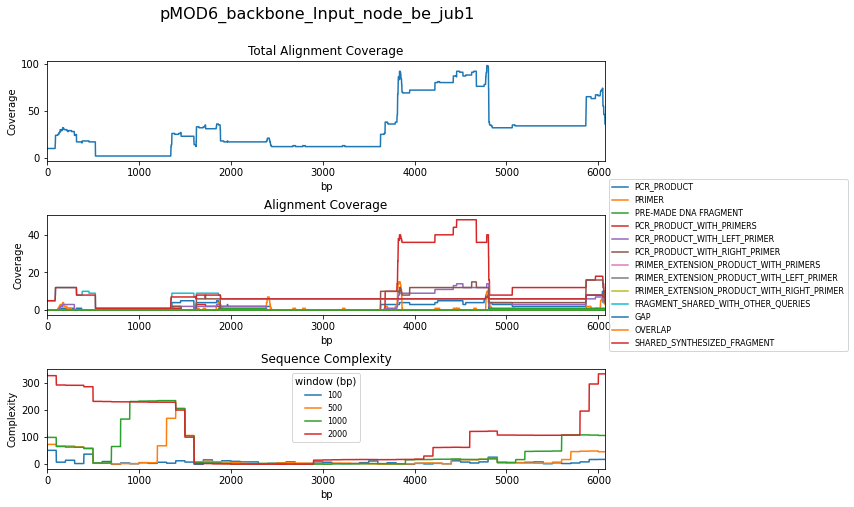

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0c55016d0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


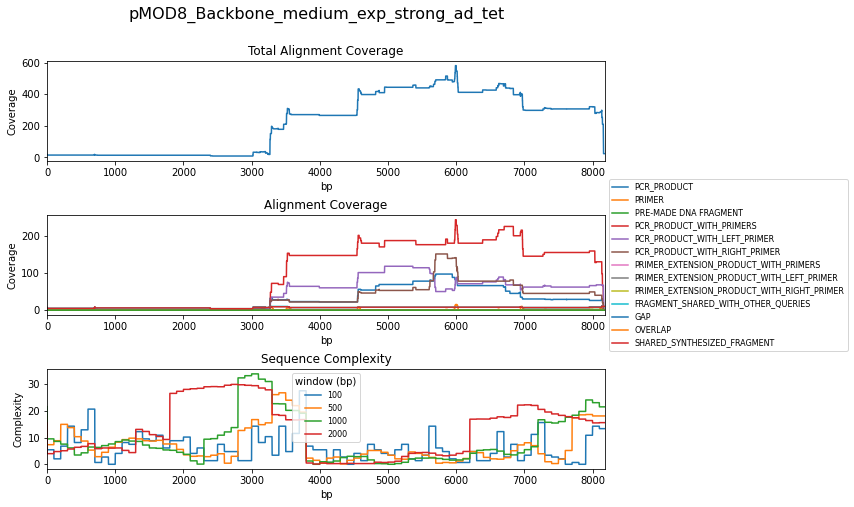

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a00e6bb0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


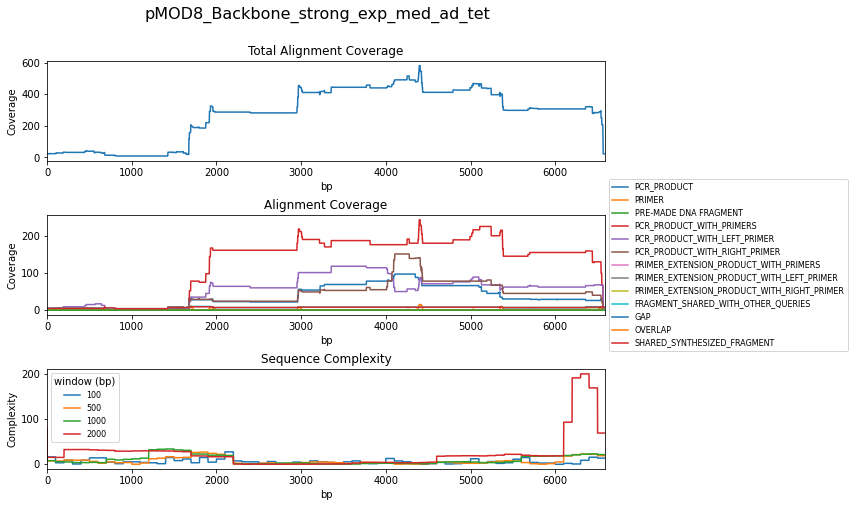

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc1075a2790> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


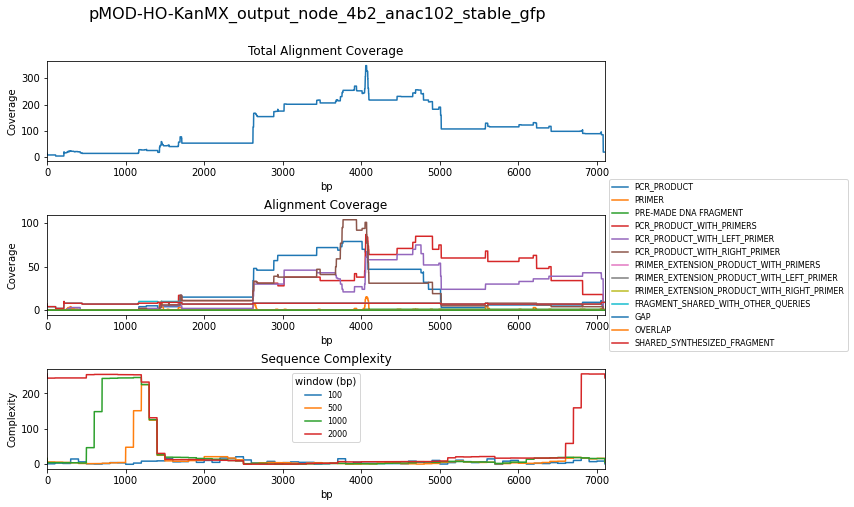

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0d0255b50> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


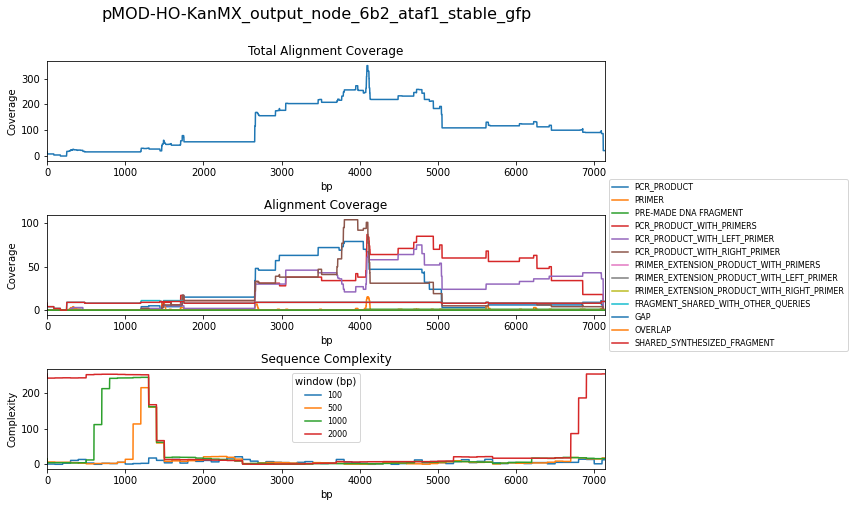

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc1080fd2b0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


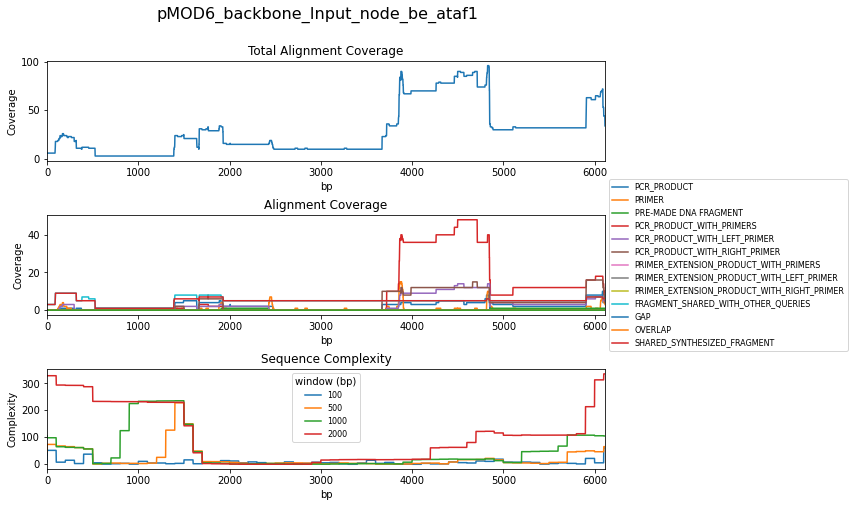

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a06485e0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


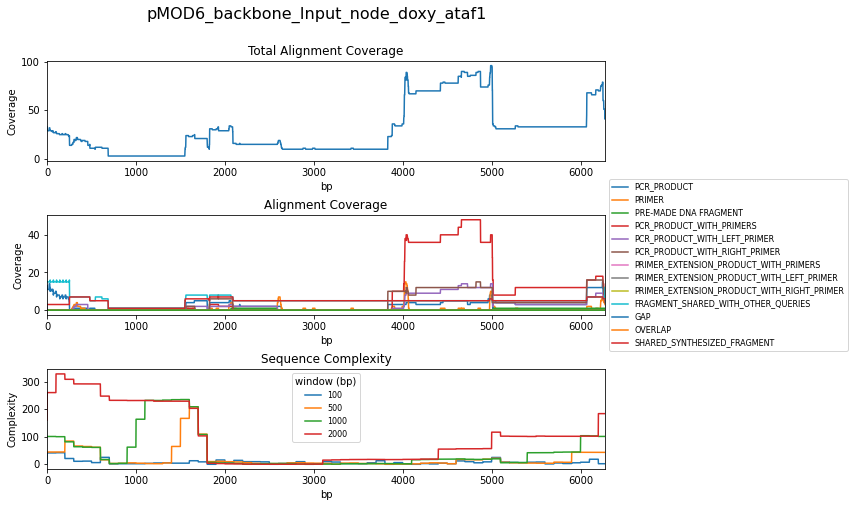

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc1843c0070> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


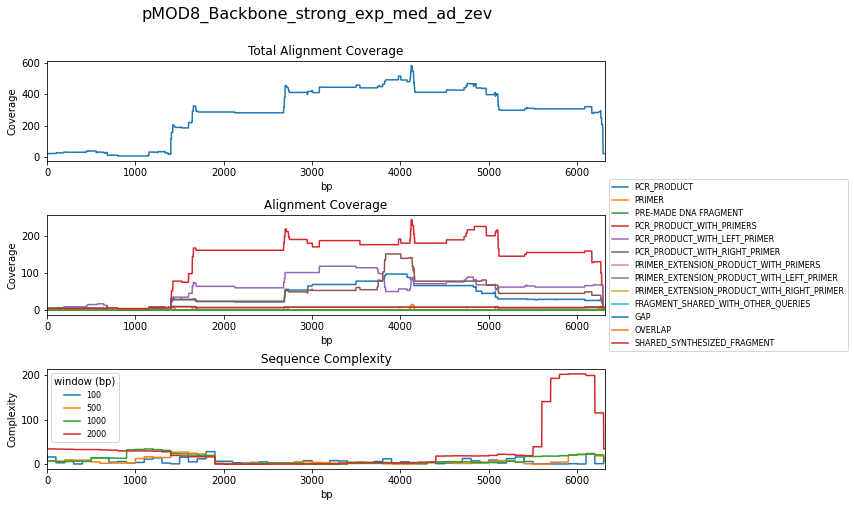

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0cb92fa30> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


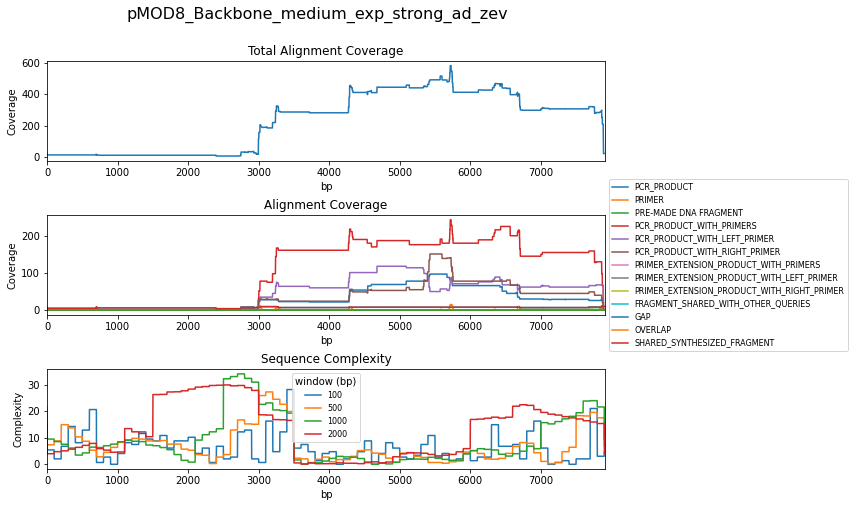

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a5711820> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


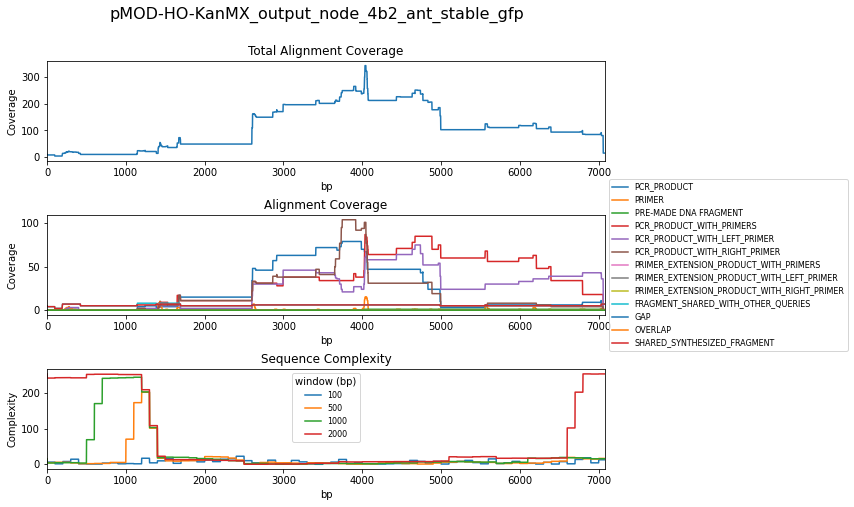

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0c1137940> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


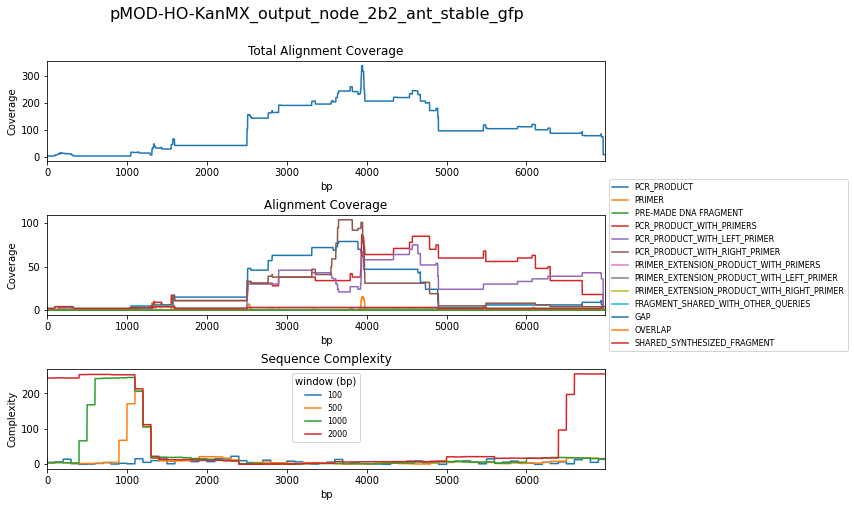

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0c0792730> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


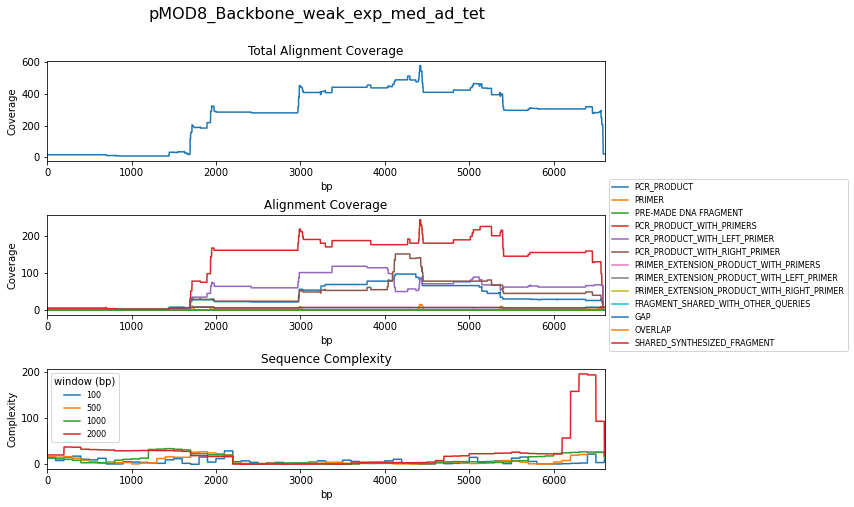

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc1047d8d90> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


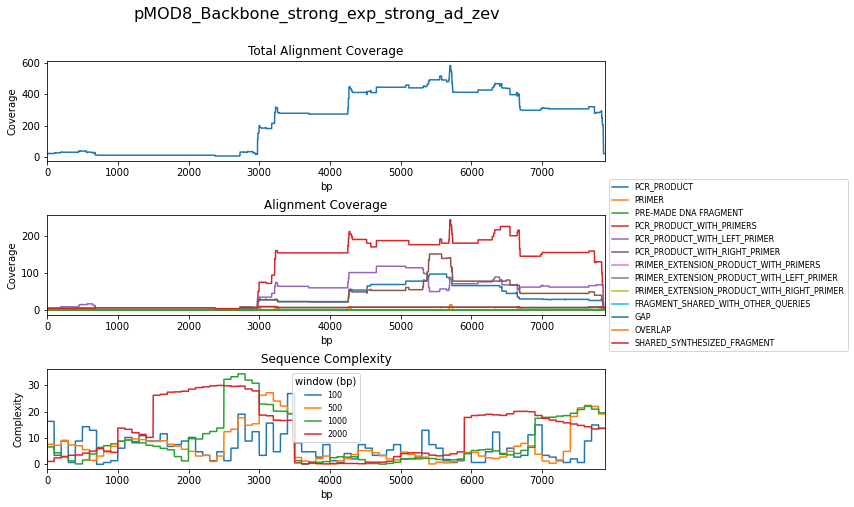

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0ca981eb0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


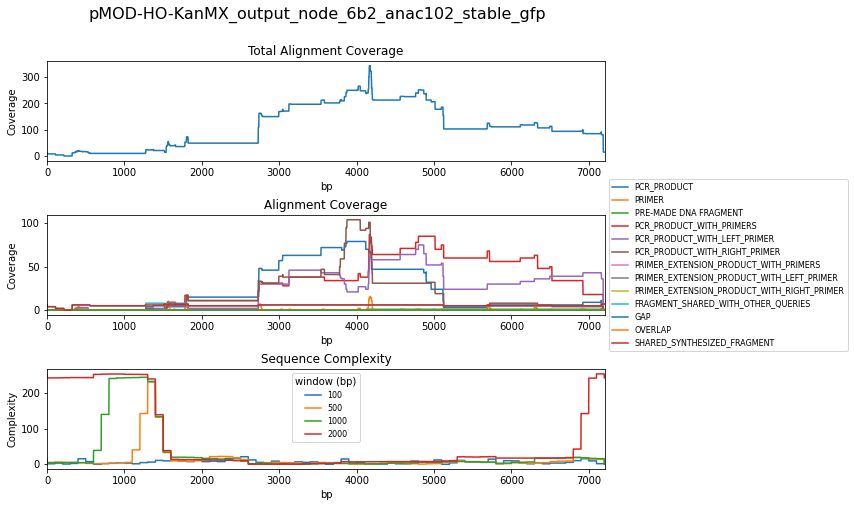

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a682adc0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


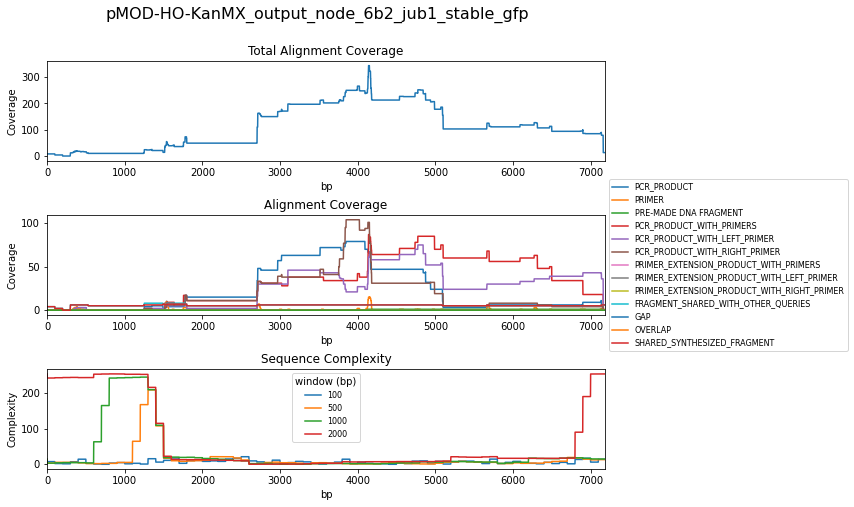

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a46b6eb0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


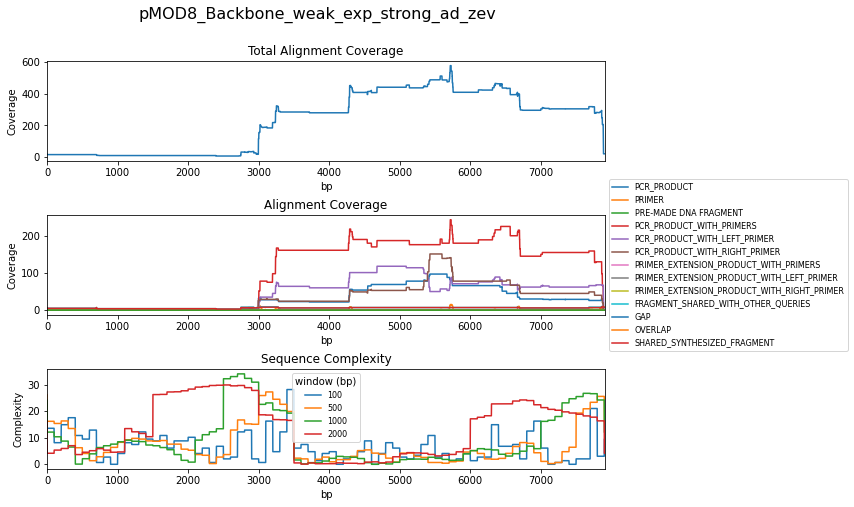

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a5889af0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


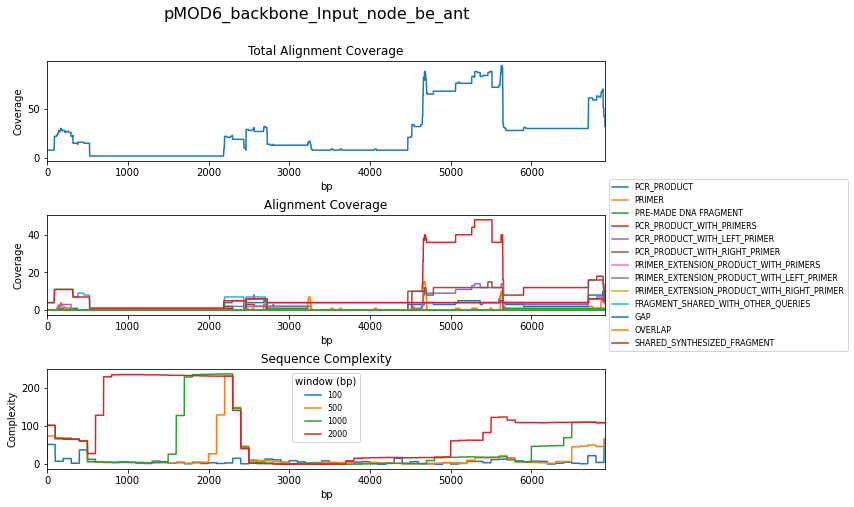

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc1040c1730> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


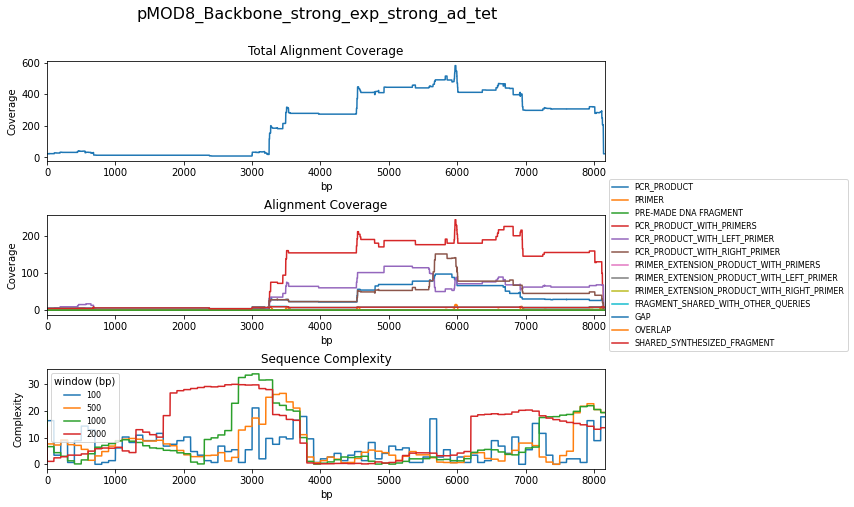

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc13b8df580> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


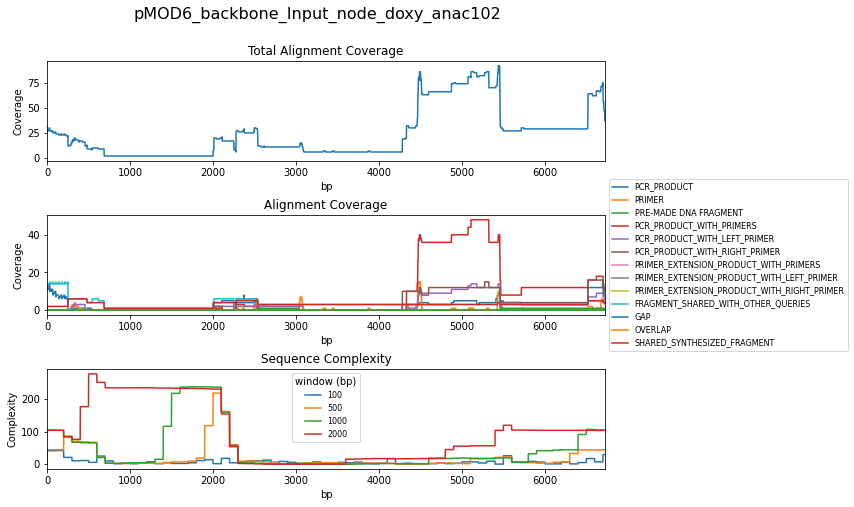

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a09134c0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


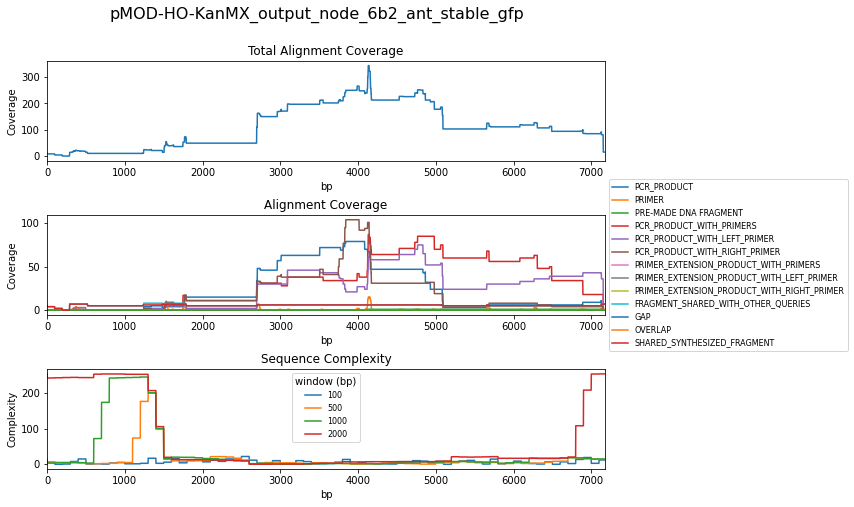

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc09b933760> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


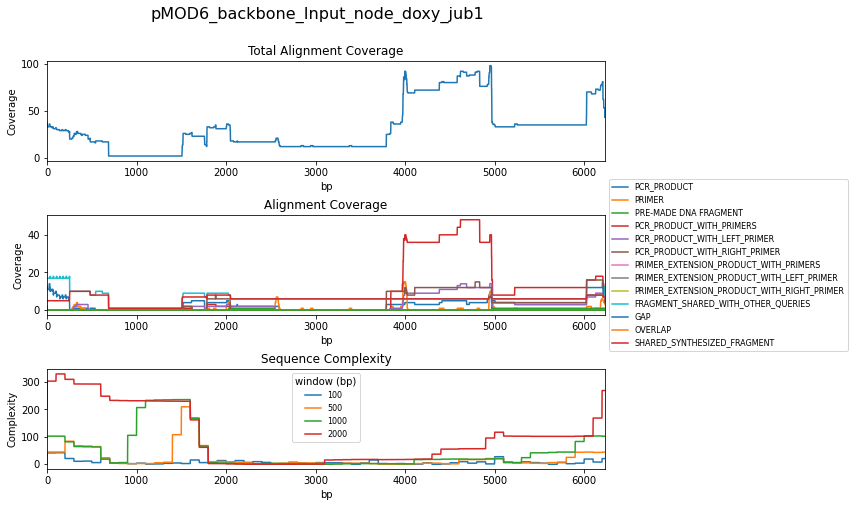

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0c084de50> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


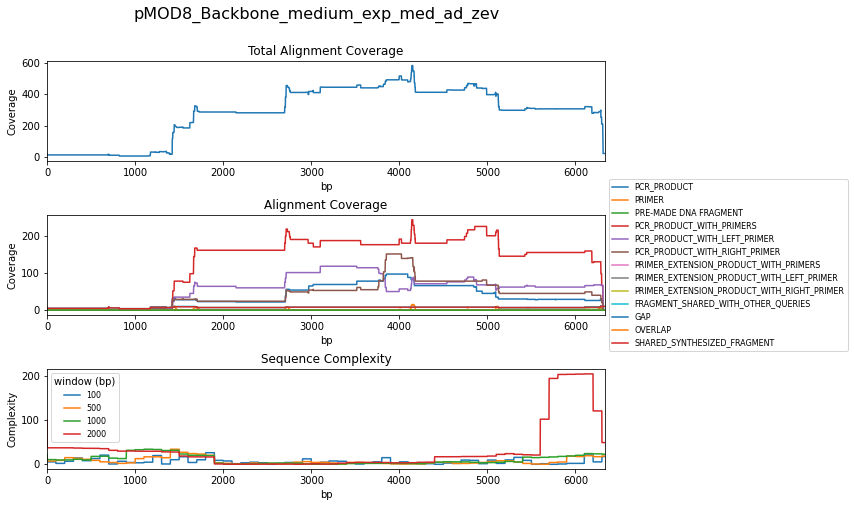

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a194cbb0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


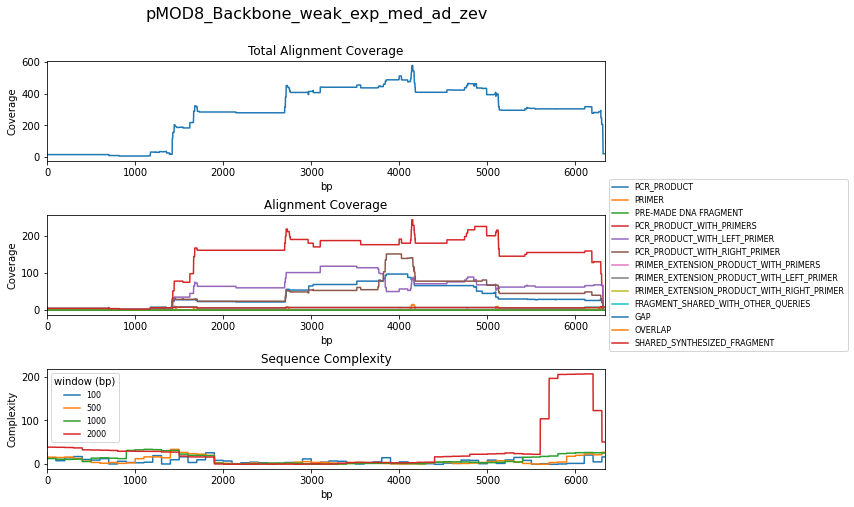

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a09523d0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


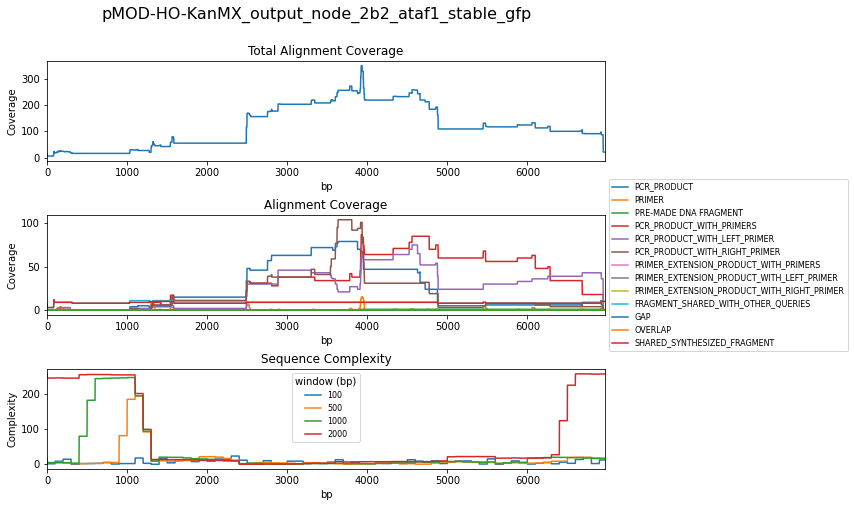

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0c0162e20> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


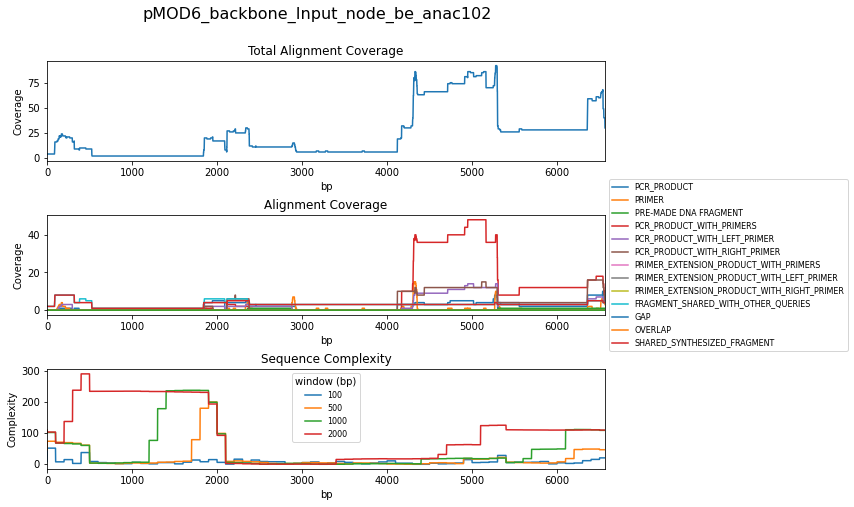

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a06b9520> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


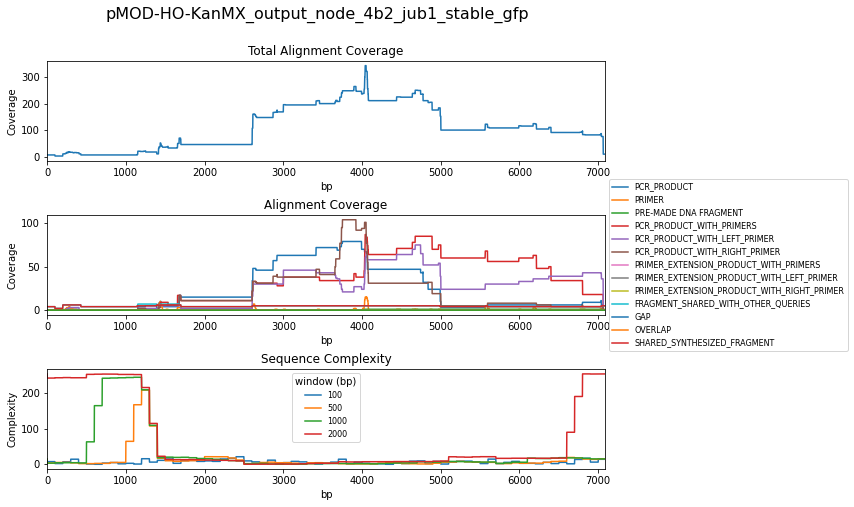

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a0a2dee0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


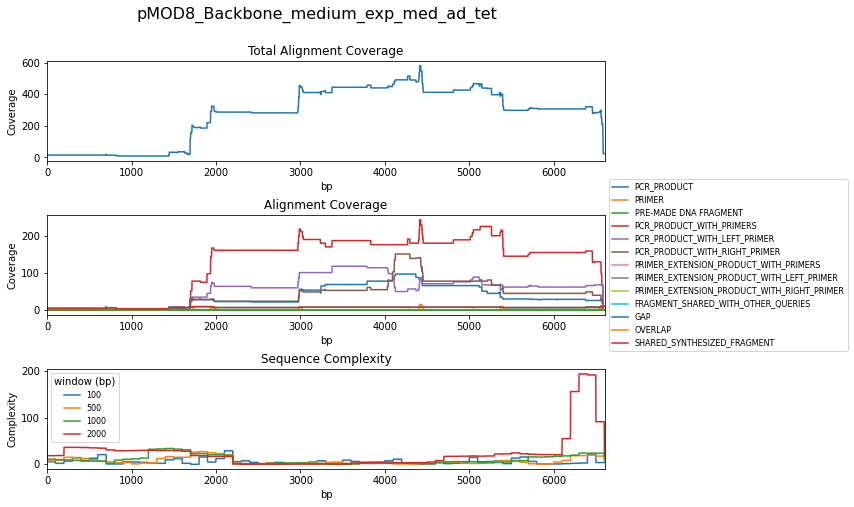

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0a4586c10> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


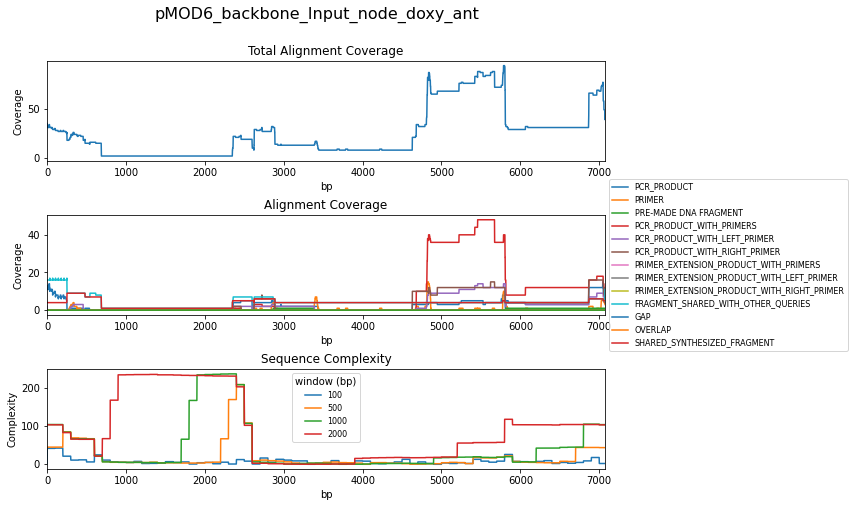

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc09b668d30> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


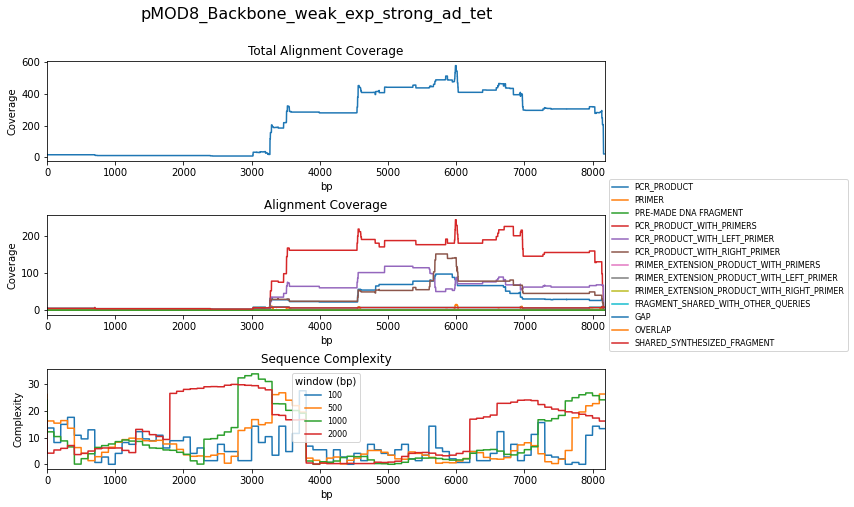

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc103ab5580> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


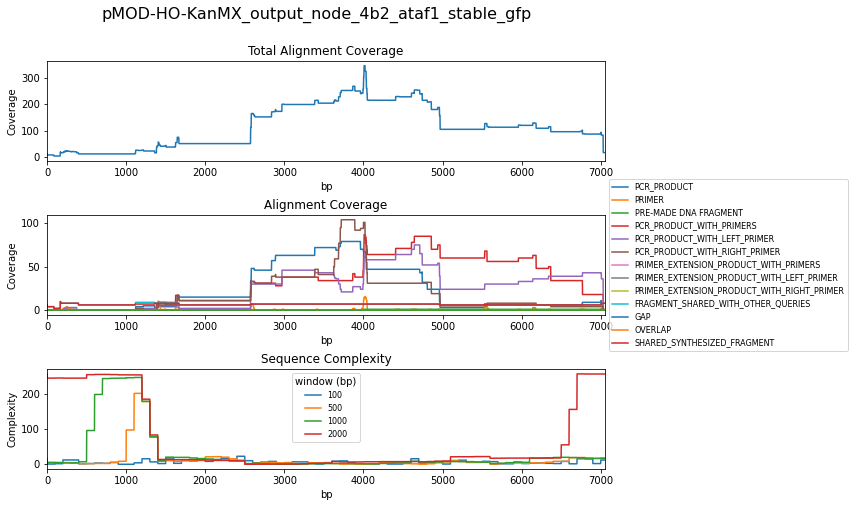

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc09b59a610> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


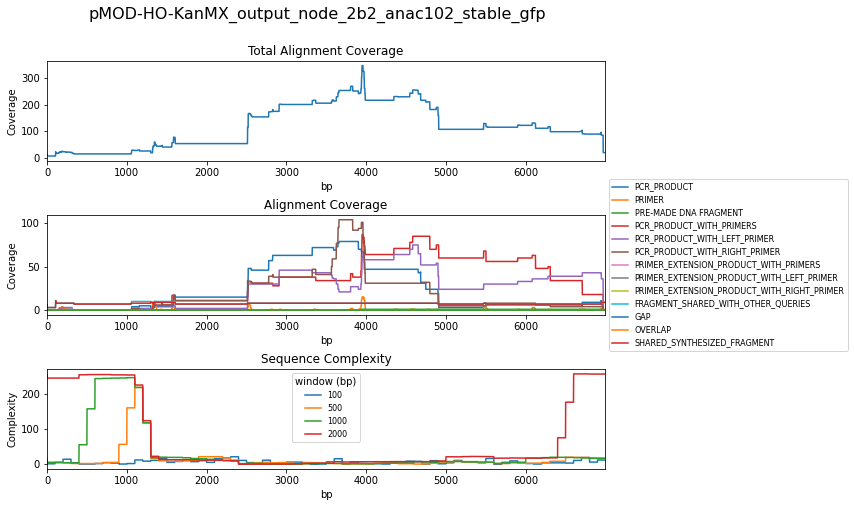

/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/dasi/design/report.py:74: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fc0c5c7cac0> has a label of '__MISSING' which cannot be automatically added to the legend.
  ax2.legend(keys, loc="center left", ncol=1, bbox_to_anchor=(1.0, 0.5))


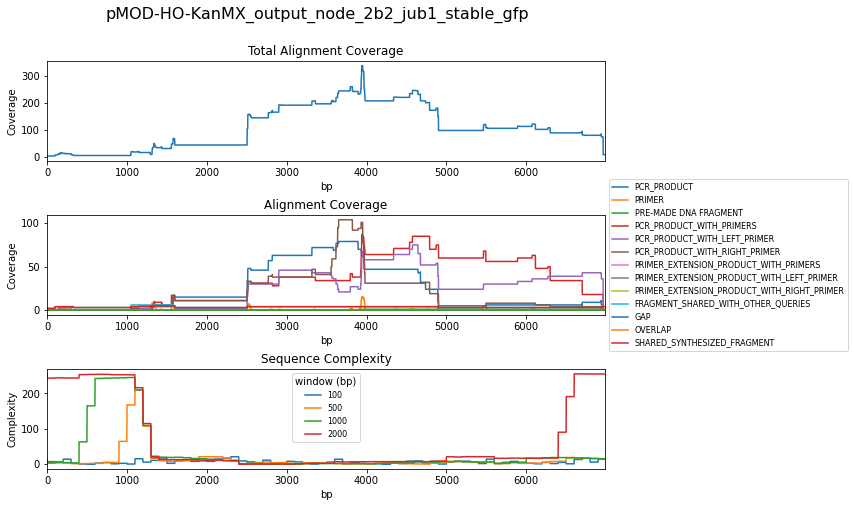

{'1088e2e5-196d-412f-8dc6-41308bdc2810': (<Figure size 720x540 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fc0a0368c70>]),
 '78acc573-6e18-4ab8-a66d-fb9a99ccf9c3': (<Figure size 720x540 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fc0a0051580>]),
 'b6bf91eb-2b68-4478-9522-c9cf1a4cb1ea': (<Figure size 720x540 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fc0c055e820>]),
 '6f3dc5a2-2cbb-41f2-aa14-a64aa276b658': (<Figure size 720x540 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fc0a05940d0>]),
 '1325c171-e6c9-4975-8c6d-c80bd44e1705': (<Figure size 720x540 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fc0c13d4970>]),
 '93a4af9a-c85e-461b-aec8-8593add6294a': (<Figure size 720x540 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fc0c122c7c0>]),
 '169cbdf0-b9fa-4fcb-8445-7caf3b08338e': (<Figure size 720x540 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fc100741160>]),
 '4a1345f5-7b

In [12]:
design.report().plot_coverage(show=True)